<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Viterbi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Objective: Create segments that contains bouts of calling

In [ ]:
import librosa
import os
from librosa import display
import scipy
import numpy as np
from matplotlib import pyplot as plt
import math

###Step 1: Calculate the probability of call state given amplitude
Original code can be found in the notebook Minimum_threshold.ipynb

In [ ]:
def z_score(data,average,std):
  error = math.exp(-10000)
  z = (data-average)/(std+error)
  return z

def logistic_function(x,threshold,std):
  probability = 1/(1+math.exp(-(x-threshold)))
  return probability
 
def state_probability(file_path):
  file_name = os.path.basename(file_path)
  sampling_rate = 44100
  samples, sampling_rate = librosa.load(file_path,sr=sampling_rate)

  hilbert_signal = abs(scipy.signal.hilbert(samples))
  hilbert_signal = scipy.ndimage.filters.gaussian_filter1d(hilbert_signal,sigma=5)

  #time vector
  duration = len(samples)/sampling_rate
  x_time = np.arange(0,duration,1/sampling_rate)

  #get statistics for the amplitudes
  mean_amplitude = np.mean(hilbert_signal)
  stdev = np.std(hilbert_signal)

  normalized_signal = z_score(hilbert_signal,mean_amplitude,stdev)

  std_normalized = np.std(normalized_signal)

  vectorized_logistics = np.vectorize(logistic_function)

  #data points with z_score>3 categorized into yes call state
  probability_each_point = vectorized_logistics(normalized_signal,2,std_normalized)

  return probability_each_point

#####testing to ensure the function works

In [ ]:
file_path='/content/Laevis_01-F818D-F8387-220616_0456_8min_selection.wav'
probability_each_point = state_probability(file_path)

In [ ]:
probability_each_point.min()

0.07624232953745715

In [ ]:
sampling_rate = 44100
samples, sampling_rate = librosa.load(file_path,sr=sampling_rate)

#time vector
duration = len(samples)/sampling_rate
x_time = np.arange(0,duration,1/sampling_rate)

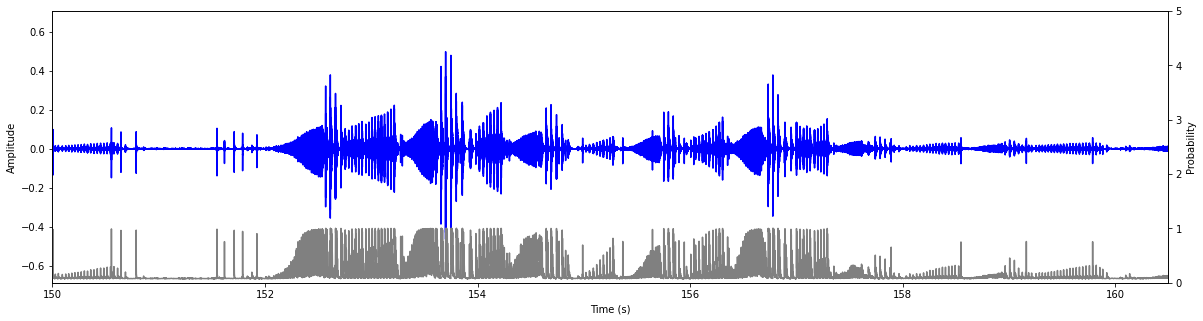

In [ ]:
#plot true signal and probability likelihood
figure,ax1 = plt.subplots()
figure.set_size_inches(20,5)
ax1.plot(x_time,samples,color='blue')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")

ax2 = ax1.twinx()
ax2.plot(x_time,probability_each_point,color='grey')
ax2.set_ylabel("Probability")
ax2.set_ylim(0,5)

ax2.set_xlim(150,160.5)
plt.show()

###Step 2: Setting the parameters and run Viterbi_discriminative

Parameter 1: prob

In [ ]:
def prob_generate(probability_each_point):
  yes_call_prob = probability_each_point
  no_call_prob = [1-i for i in yes_call_prob]
  prob = np.row_stack((yes_call_prob,no_call_prob))
  return prob

In [ ]:
prob = prob_generate(probability_each_point)

In [ ]:
np.array(prob).shape

(2, 20896891)

Parameter 2: transition matrix (2*2)

In [ ]:
#assumption that the transition between states is less likely compared to within states
yes_to_no = 0.1
no_to_yes = yes_to_no
transition_matrix = np.row_stack(([1-yes_to_no,yes_to_no],[no_to_yes,1-no_to_yes]))

In [ ]:
transition_matrix

array([[0.9, 0.1],
       [0.1, 0.9]])

Parameter 3: p_init

In [ ]:
yes_init = 0.1
p_init = np.array([0.3,0.7])

In [ ]:
p_init

array([0.3, 0.7])

Run the viterbi_discrimative algorithm

In [ ]:
states = librosa.sequence.viterbi_discriminative(prob,transition_matrix,p_init=p_init)

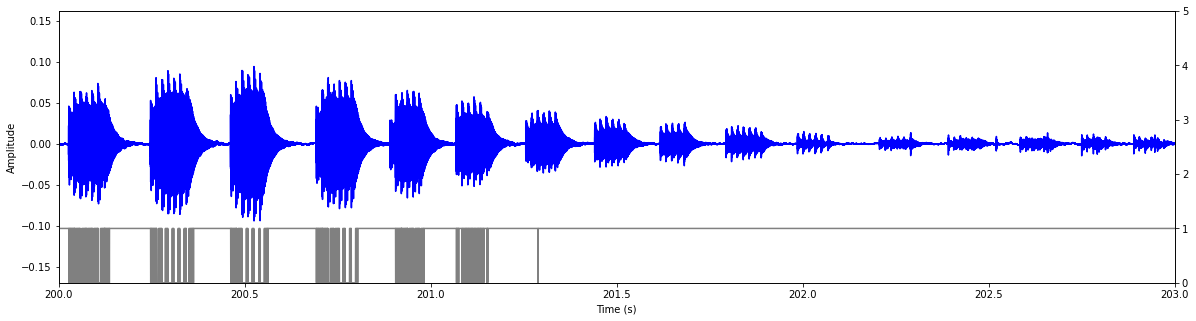

In [ ]:
figure,ax1 = plt.subplots()
figure.set_size_inches(20,5)
ax1.plot(x_time,samples,color='blue')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")

ax2 = ax1.twinx()
ax2.plot(x_time,states,color='grey')
ax2.set_ylim(0,5)
ax2.set_xlim(200,203)
plt.show()